# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [ ]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [ ]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(in1 = image, 
                                              in2 = gaussFilter, 
                                              mode = 'same', 
                                              boundary = 'fill', 
                                              fillvalue = 0)

filterResponseSobelX = signal.convolve2d(in1 = image, 
                                              in2 = sobelX, 
                                              mode = 'same', 
                                              boundary = 'fill', 
                                              fillvalue = 0)

filterResponseSobelY = signal.convolve2d(in1 = image, 
                                              in2 = sobelY, 
                                              mode = 'same', 
                                              boundary = 'fill', 
                                              fillvalue = 0)

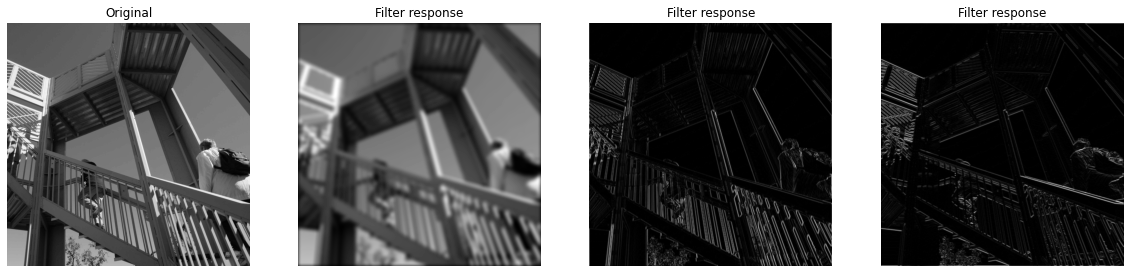

In [ ]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions


Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

**Gaussian filter detects the lowpass, whereas,SobelX detects the vertical edges and SobelY detects the Horizental edges**

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?  

**The size of the original image is 32 * 32, and the number of channels is normally three RGB**

Question 3: What is the size of the different filters?  

**The size of the different filters is 3*3**

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?  
**When using the mode 'same' we will have the same size of the input in the output, because the mode same indicates the use of the same input size. and the filter will go outside the bound of the input by (filter_size/2)**

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter?  
**When the valid filter is used, then the convolution is computed when the filter and the input fully overlap, and the output will be smaller than the input**

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?  

**Because the size of the input will be reduced by a small amount after each convolution, and for many layers, the last layers will have a very small input size**


In [ ]:
# Your code for checking sizes of image and filter responses
print(image.shape)
print(filterResponseGauss.shape)
print(filterResponseSobelX.shape)
print(filterResponseSobelY.shape)


(512, 512)
(512, 512)
(512, 512)
(512, 512)


##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ?  

**The filter takes a three dimensions to enable it to capture features both in the spatial as well as temporal domain for classification purposes, and they are use for video analysis**

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?  

**Conv2D creates 2D convolutional layers, which  takes a three dimensional input,with three color channels. Then it passes a filter over the image, inspecting a small window of pixels at a time a 3*3 in our case, and moves the window until the entired image is scanned. The convolution operation calculates the dot product of the pixel values in the current filter window with the weights defined in the filter.**

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?  

**The CPU time was 3.11700791200019, whereas the GPU time was 0.10209885699987353, so GPU speedup over CPU: 30x**

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.  
**While using 2 images, the GPU was also faster than the CPU with 0.11848281600032351 time for the CPU and 0.04501205100041261 for the GPU. but the difference is minor, the GPU speedup over CPU was 2x, that was because the data is smal in size and the GPU didn't use it's maximum power like it did when we gave it 100 images and it showed the difference**

Reference: https://missinglink.ai/guides/keras/keras-conv2d-working-cnn-2d-convolutions-keras/ 

In [ ]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.13756630700027017
GPU (s):
0.06950699099979829
GPU speedup over CPU: 1x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [ ]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

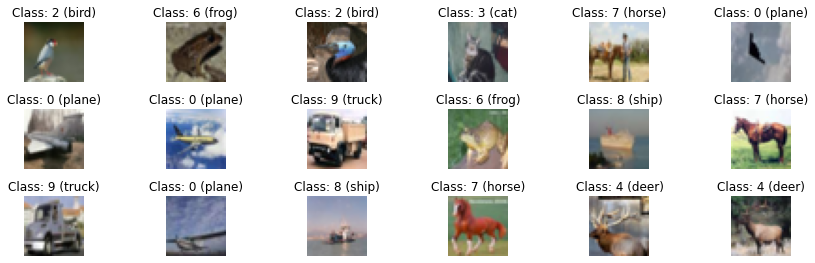

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, 
                                              Ytrain, 
                                              test_size = 0.25)

print("Training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Validation images have size %s and labels have size %s \n" % (Xval.shape, Yval.shape))

# Print the size of training data, validation data and test data


Training images have size (7500, 32, 32, 3) and labels have size (7500, 1) 
Validation images have size (2500, 32, 32, 3) and labels have size (2500, 1) 



##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [ ]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [ ]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print("############## Before converting the labels ##############")
print("Training labels have size {}".format(Ytrain.shape))
print("Validation labels have size {}".format(Yval.shape))
print("Test labels have size {}".format(Ytest.shape))
print("############## Before converting the labels ##############")

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain, 
               num_classes = 10, 
               dtype = 'int32')

Yval = to_categorical(Yval, 
               num_classes = 10, 
               dtype = 'int32')

Ytest = to_categorical(Ytest, 
               num_classes = 10, 
               dtype = 'int32')

# Print shapes after converting the labels
print("############## After converting the labels ##############")
print("Training labels have size {}".format(Ytrain.shape))
print("Validation labels have size {}".format(Yval.shape))
print("Test labels have size {}".format(Ytest.shape))
print("############## After converting the labels ##############")


############## Before converting the labels ##############
Training labels have size (7500, 1)
Validation labels have size (2500, 1)
Test labels have size (2000, 1)
############## Before converting the labels ##############
############## After converting the labels ##############
Training labels have size (7500, 10)
Validation labels have size (2500, 10)
Test labels have size (2000, 10)
############## After converting the labels ##############


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy as CC
from keras.layers.normalization import BatchNormalization

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    opti = Adam(lr=learning_rate)

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters = n_filters, 
                     kernel_size = (3,3), 
                     padding = 'same', 
                     activation = 'relu', 
                     input_shape = input_shape))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
          model.add(Conv2D(filters = n_filters * (i + 1), 
                     kernel_size = (3,3), 
                     padding = 'same', 
                     activation = 'relu', 
                     input_shape = input_shape))
          
          model.add(BatchNormalization())
          model.add(MaxPooling2D(pool_size = (2,2)))

    # Add flatten layer
    model.add(Flatten())
    
    # Add intermediate dense layers
    for i in range(n_dense_layers):
          model.add(Dense(n_nodes, 
                          activation = 'relu', 
                          input_dim = input_shape))
          model.add(BatchNormalization())
          if use_dropout == True:
            model.add(Dropout(0.5))
    # Add final dense layer
    model.add(Dense(10, 
                    activation = 'softmax'))
   
    # Compile model
    model.compile(optimizer = opti,
                  loss = CC, 
                  metrics = ['accuracy'])
    
    return model

In [ ]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [ ]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])
print(input_shape)
# Build model
model1 = build_CNN(input_shape, 
                   n_conv_layers=2, 
                   n_filters=16, 
                   n_dense_layers=0, 
                   n_nodes=50, 
                   use_dropout=False, 
                   learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(x = Xtrain,
                      y = Ytrain,
                      validation_data = (Xval,Yval),
                      epochs = epochs,
                      batch_size = batch_size)
model1.summary()

(32, 32, 3)
Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 246us/step - loss: 2.1809 - accuracy: 0.3432 - val_loss: 1.8705 - val_accuracy: 0.3056
Epoch 2/20
7500/7500 [==============================] - 1s 170us/step - loss: 1.4794 - accuracy: 0.4805 - val_loss: 1.6920 - val_accuracy: 0.3908
Epoch 3/20
7500/7500 [==============================] - 1s 162us/step - loss: 1.3025 - accuracy: 0.5355 - val_loss: 1.5609 - val_accuracy: 0.4624
Epoch 4/20
7500/7500 [==============================] - 1s 162us/step - loss: 1.1720 - accuracy: 0.5796 - val_loss: 1.3491 - val_accuracy: 0.5332
Epoch 5/20
7500/7500 [==============================] - 1s 163us/step - loss: 1.1103 - accuracy: 0.6024 - val_loss: 1.2969 - val_accuracy: 0.5536
Epoch 6/20
7500/7500 [==============================] - 1s 164us/step - loss: 1.0290 - accuracy: 0.6348 - val_loss: 1.2918 - val_accuracy: 0.5500
Epoch 7/20
7500/7500 [==============================] - 1s 162us

In [ ]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(x = Xtest, 
                        y = Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 147us/step
Test loss: 2.0086
Test accuracy: 0.5455


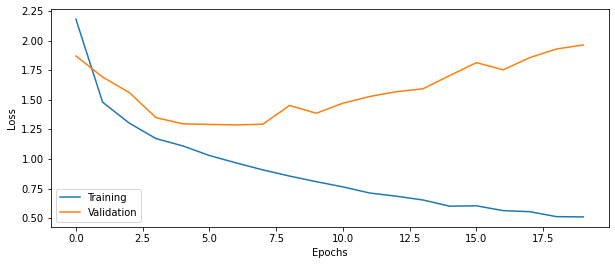

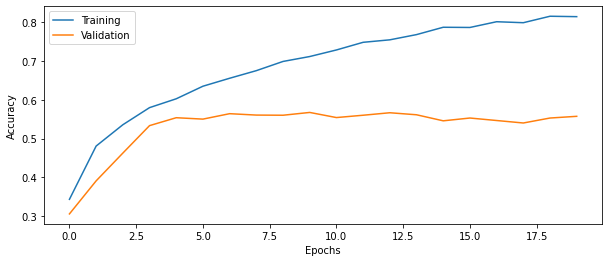

In [ ]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ?  

**The performance was pretty low in this case with 53% accuracy**

Question 11: How big is the difference between training and test accuracy?  

**The training accuracy was close to 80%, but the test accuracy was only 53%**

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training.  
**using google colab**

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?  

**Because our data is images 32 * 32 with 3*3 filters, so a smaller batch size here means a large amount of data, as it encompases image pixels and also filters, in addition to the movement of filters over the image (convolution)**

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [ ]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])

# Build model
model2 = build_CNN(input_shape, 
                   n_conv_layers=2, 
                   n_filters=16, 
                   n_dense_layers=1, 
                   n_nodes=50, 
                   use_dropout=False, 
                   learning_rate=0.01)

# Train the model  using training data and validation data
history2 = model2.fit(x = Xtrain,
                      y = Ytrain,
                      validation_data = (Xval,Yval),
                      epochs = epochs,
                      batch_size = batch_size)
model2.summary()

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 258us/step - loss: 1.6789 - accuracy: 0.4112 - val_loss: 2.1593 - val_accuracy: 0.2588
Epoch 2/20
7500/7500 [==============================] - 1s 182us/step - loss: 1.2865 - accuracy: 0.5397 - val_loss: 1.8584 - val_accuracy: 0.3748
Epoch 3/20
7500/7500 [==============================] - 1s 180us/step - loss: 1.1153 - accuracy: 0.6063 - val_loss: 1.4960 - val_accuracy: 0.4852
Epoch 4/20
7500/7500 [==============================] - 1s 182us/step - loss: 0.9539 - accuracy: 0.6609 - val_loss: 1.3273 - val_accuracy: 0.5468
Epoch 5/20
7500/7500 [==============================] - 1s 178us/step - loss: 0.7960 - accuracy: 0.7205 - val_loss: 1.3718 - val_accuracy: 0.5612
Epoch 6/20
7500/7500 [==============================] - 1s 179us/step - loss: 0.6560 - accuracy: 0.7661 - val_loss: 1.5587 - val_accuracy: 0.5752
Epoch 7/20
7500/7500 [==============================] - 1s 186us/step - loss

In [ ]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(x = Xtest, 
                        y = Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 137us/step
Test loss: 3.1719
Test accuracy: 0.5355


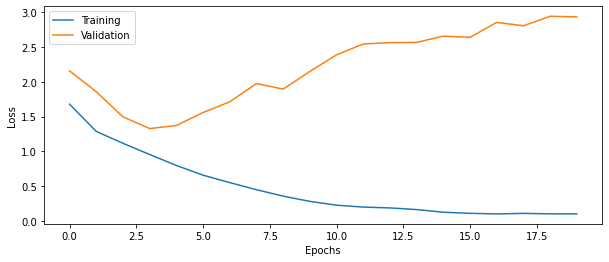

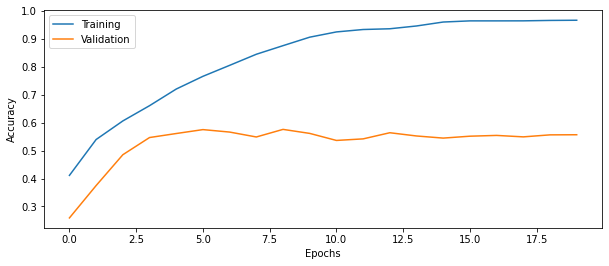

In [ ]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [ ]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])

# Build model
model3 = build_CNN(input_shape, 
                   n_conv_layers=4, 
                   n_filters=16, 
                   n_dense_layers=1, 
                   n_nodes=50, 
                   use_dropout=False, 
                   learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(x = Xtrain,
                      y = Ytrain,
                      validation_data = (Xval,Yval),
                      epochs = epochs,
                      batch_size = batch_size)
model3.summary()

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 3s 358us/step - loss: 1.7591 - accuracy: 0.3636 - val_loss: 1.6474 - val_accuracy: 0.3940
Epoch 2/20
7500/7500 [==============================] - 2s 218us/step - loss: 1.4317 - accuracy: 0.4737 - val_loss: 1.6823 - val_accuracy: 0.3968
Epoch 3/20
7500/7500 [==============================] - 2s 219us/step - loss: 1.2822 - accuracy: 0.5305 - val_loss: 1.5435 - val_accuracy: 0.4612
Epoch 4/20
7500/7500 [==============================] - 2s 222us/step - loss: 1.1466 - accuracy: 0.5868 - val_loss: 1.4675 - val_accuracy: 0.5292
Epoch 5/20
7500/7500 [==============================] - 2s 218us/step - loss: 1.0316 - accuracy: 0.6340 - val_loss: 1.3082 - val_accuracy: 0.5680
Epoch 6/20
7500/7500 [==============================] - 2s 221us/step - loss: 0.9283 - accuracy: 0.6713 - val_loss: 1.5855 - val_accuracy: 0.5452
Epoch 7/20
7500/7500 [==============================] - 2s 228us/step - loss

In [ ]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(x = Xtest, 
                        y = Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 179us/step
Test loss: 3.2250
Test accuracy: 0.5675


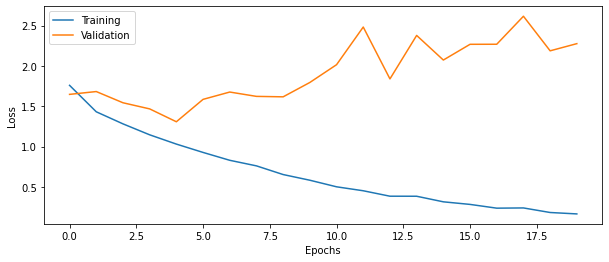

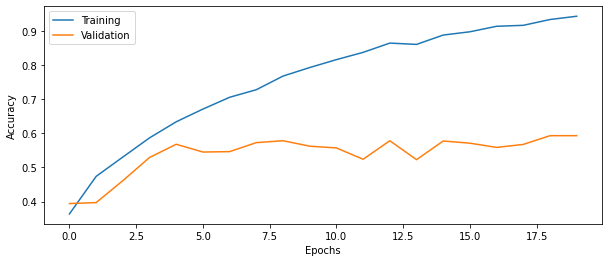

In [ ]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?  

**The number of trainable parameters is 31,764, and the part of the network with most of the parameters is the convolutional layers(conv2d_8 (Conv2D))**

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output?  
**The in put is 32 * 32 RGB images size and the output is also 32 * 32**

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/   

**Yes, the batch size is always the first dimension, whether the data format is channels_last or channels_first**

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?  

**128/32 = 4 channels**

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?  

**Because some parameters are non-trainable (324), this is due to the weights that are not updated during backpropagation**

Question 19: How does MaxPooling help in reducing the number of parameters to train?  

**MaxPooling down-samples the features representation by reducing its dimensionality and it alsow allows for making assumptions about features in sub-regions binned**

In [ ]:
# Print network architecture

model3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_42 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 32)        

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?  

**When using dropout in our intermediate dense layers, the test accuracy was worse than without dropout, but when we added dropout to both Conv layers and dense layers the test was slightly worse than without dropout. **

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?  

**We can add (kernel_regularizer=l2) as a parameter to the Conv2d layer after importing l2 from keras regularizers**


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [ ]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])

# Build model
model4 = build_CNN(input_shape, 
                   n_conv_layers=4, 
                   n_filters=16, 
                   n_dense_layers=1, 
                   n_nodes=50, 
                   use_dropout=True,
                   learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model3.fit(x = Xtrain,
                      y = Ytrain,
                      validation_data = (Xval,Yval),
                      epochs = epochs,
                      batch_size = batch_size)
model4.summary()

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 220us/step - loss: 0.1747 - accuracy: 0.9388 - val_loss: 2.3914 - val_accuracy: 0.5768
Epoch 2/20
7500/7500 [==============================] - 2s 217us/step - loss: 0.1770 - accuracy: 0.9379 - val_loss: 2.6155 - val_accuracy: 0.5700
Epoch 3/20
7500/7500 [==============================] - 2s 222us/step - loss: 0.1700 - accuracy: 0.9405 - val_loss: 2.6359 - val_accuracy: 0.5744
Epoch 4/20
7500/7500 [==============================] - 2s 224us/step - loss: 0.1498 - accuracy: 0.9500 - val_loss: 2.7326 - val_accuracy: 0.5688
Epoch 5/20
7500/7500 [==============================] - 2s 223us/step - loss: 0.1373 - accuracy: 0.9524 - val_loss: 2.4443 - val_accuracy: 0.5896
Epoch 6/20
7500/7500 [==============================] - 2s 219us/step - loss: 0.1194 - accuracy: 0.9583 - val_loss: 2.6465 - val_accuracy: 0.5808
Epoch 7/20
7500/7500 [==============================] - 2s 221us/step - loss

In [ ]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(x = Xtest, 
                        y = Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2000/2000 [==============================] - 0s 228us/step
Test loss: 2.3063
Test accuracy: 0.0950


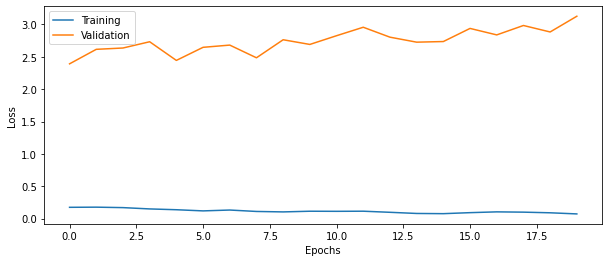

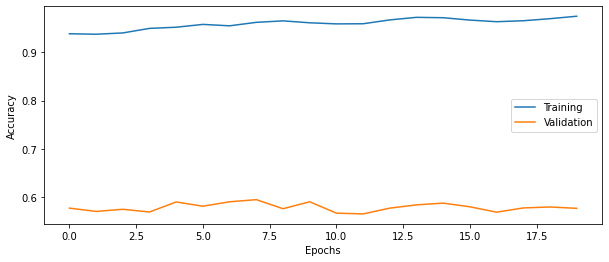

In [ ]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?  
**The highest test accuracy we could get was 0.6240**

## Your best config

In [ ]:
# Setup some training parameters
batch_size = 100
epochs = 30
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])

# Build model
model5 = build_CNN(input_shape, 
                   n_conv_layers=4, 
                   n_filters=32, 
                   n_dense_layers=1, 
                   n_nodes=50, 
                   use_dropout=False, 
                   learning_rate=0.01)

# Train the model  using training data and validation data
history5 = model5.fit(x = Xtrain,
                      y = Ytrain,
                      validation_data = (Xval,Yval),
                      epochs = epochs,
                      batch_size = batch_size)
model5.summary()


Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 3s 405us/step - loss: 1.7131 - accuracy: 0.3799 - val_loss: 1.9709 - val_accuracy: 0.3540
Epoch 2/30
8000/8000 [==============================] - 2s 283us/step - loss: 1.3724 - accuracy: 0.4976 - val_loss: 1.8919 - val_accuracy: 0.3665
Epoch 3/30
8000/8000 [==============================] - 2s 282us/step - loss: 1.2005 - accuracy: 0.5734 - val_loss: 1.4230 - val_accuracy: 0.5325
Epoch 4/30
8000/8000 [==============================] - 2s 273us/step - loss: 0.9966 - accuracy: 0.6417 - val_loss: 1.3272 - val_accuracy: 0.5620
Epoch 5/30
8000/8000 [==============================] - 2s 273us/step - loss: 0.8498 - accuracy: 0.6995 - val_loss: 1.7931 - val_accuracy: 0.5215
Epoch 6/30
8000/8000 [==============================] - 2s 272us/step - loss: 0.7143 - accuracy: 0.7465 - val_loss: 1.8252 - val_accuracy: 0.5250
Epoch 7/30
8000/8000 [==============================] - 2s 273us/step - loss

In [ ]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(x = Xtest, 
                        y = Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 192us/step
Test loss: 2.5509
Test accuracy: 0.6210


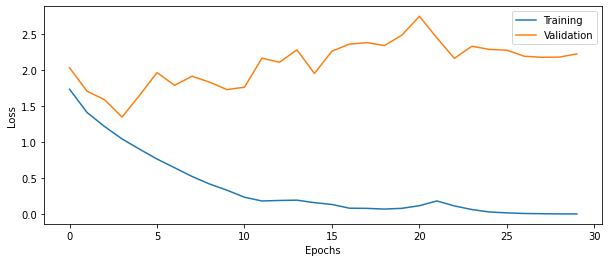

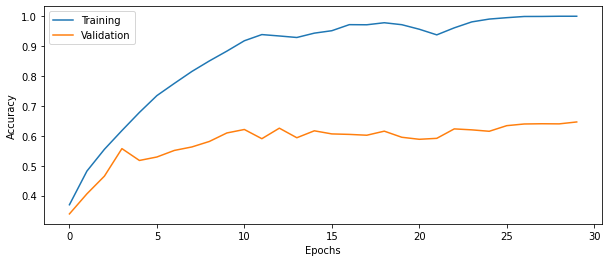

In [ ]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.  
**The accuracy for the rotated image is lower than that of the original images (withouth rotation), because when we rotate the image, this will result in change in pixels location, so the filter that learned during the training will have different pixels with different colors density representation, this will then result in a low accuracy level.**




In [ ]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

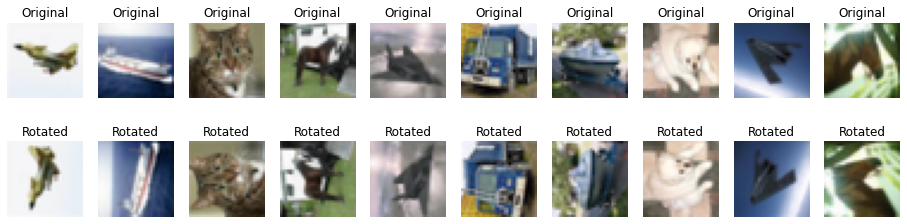

In [ ]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [ ]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(x = Xtest_rotated, 
                        y = Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 141us/step
Test loss: 7.6347
Test accuracy: 0.2280


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [ ]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [ ]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(rotation_range=30,
                             horizontal_flip=True, 
                             vertical_flip=True,
                             validation_split=0.2)

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, 
                                              Ytrain, 
                                              test_size = 0.20)
# Setup a flow for training data, assume that we can fit all images into CPU memory
train_generator = datagen.flow(Xtrain, Ytrain, batch_size=batch_size, subset='training')
# Setup a flow for validation data, assume that we can fit all images into CPU memory
validation_generator = datagen.flow(Xtrain, Ytrain, batch_size=batch_size, subset='validation')
validation_generator = datagen.flow(Xval, Yval, batch_size=1000)

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?  

**If we can't fit all data into the CPU memory, when we can set a batch size so that our data is not taken all at once, but divided into batches and processed**

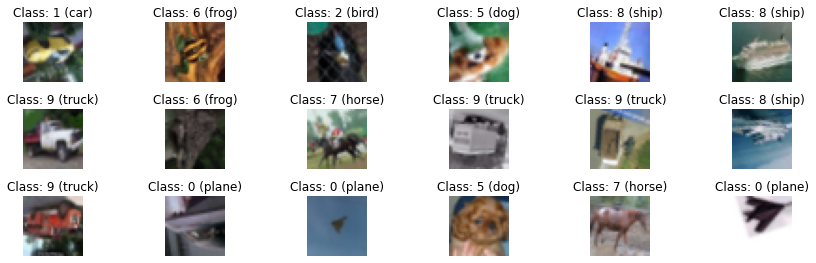

In [ ]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?  
**The training accuracy was increasing slowly compared to without augmentation, our network was learning very slowly.When we perform the augmentation we considered our CPU could fit the whole data, and we augment the image first, so we create artificial images**

Question 26: What other types of image augmentation can be applied, compared to what we use here?  

**we can use random rotation, shifts, shear and flips. we can also use Augmented Images using Contrast Stretching, Histogram Equalization, or Adaptive Histogram Equalization to generate different types of augmented images**

In [ ]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])

# Build model (your best config)
model6 = build_CNN(input_shape, 
                   n_conv_layers=4, 
                   n_filters=32, 
                   n_dense_layers=1, 
                   n_nodes=50, 
                   use_dropout=False, 
                   learning_rate=0.01)

validation_split=0.2

# Train the model using on the fly augmentation
history6 = model6.fit_generator(train_generator,
                                steps_per_epoch = len(Xtrain)*(1 - validation_split)/batch_size,
                                epochs = epochs,
                                validation_data = validation_generator,
                                validation_steps = len(Xtrain)*validation_split/batch_size,)
model6.summary()

Epoch 1/200
64/64 [==============================] - 14s 213ms/step - loss: 1.9512 - accuracy: 0.2875 - val_loss: 2.0634 - val_accuracy: 0.2619
Epoch 2/200
64/64 [==============================] - 12s 194ms/step - loss: 1.6849 - accuracy: 0.3725 - val_loss: 2.2659 - val_accuracy: 0.2431
Epoch 3/200
64/64 [==============================] - 13s 196ms/step - loss: 1.5989 - accuracy: 0.4078 - val_loss: 1.8611 - val_accuracy: 0.3652
Epoch 4/200
64/64 [==============================] - 12s 194ms/step - loss: 1.5472 - accuracy: 0.4327 - val_loss: 1.5843 - val_accuracy: 0.4141
Epoch 5/200
64/64 [==============================] - 12s 194ms/step - loss: 1.4703 - accuracy: 0.4609 - val_loss: 1.6769 - val_accuracy: 0.4236
Epoch 6/200
64/64 [==============================] - 12s 194ms/step - loss: 1.4210 - accuracy: 0.4841 - val_loss: 1.5944 - val_accuracy: 0.4427
Epoch 7/200
64/64 [==============================] - 12s 195ms/step - loss: 1.3694 - accuracy: 0.4983 - val_loss: 1.5100 - val_accuracy:

In [ ]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


Test loss: 1.6827
Test accuracy: 0.6320


**The difference now is less than it was, after using the data generator and 200 epochs, now we have a test accuracy of 0.6405. whereas before using the data generator, the difference was 37. So, it is a significant change in the accuracy of the augmented images.**

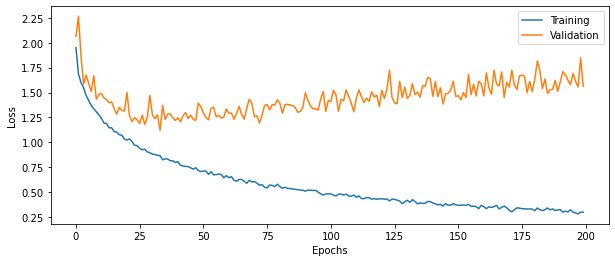

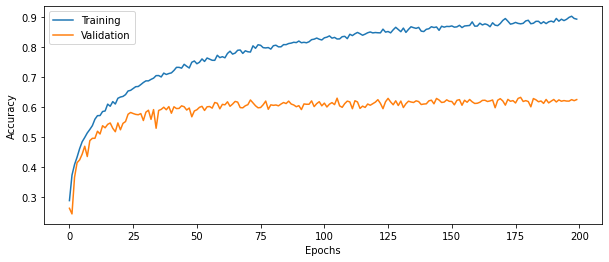

In [ ]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [ ]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

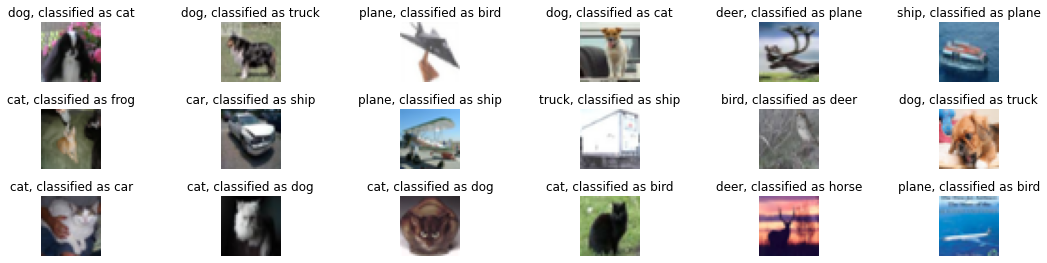

In [ ]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?  
**It can't be applied to images of another size because it has an input_shape of 32 *32, so the images fed to this CNN must be 32 *32.**

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?  

**It could be possible if we first check the input shape, and train our model according to that specific input_shape first, then we can use it to test images with the size of that only input_shape.**

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have?   
**34 Layers**

Question 30: How many trainable parameters does the ResNet50 network have?  

**25,583,592 parameters**

Question 31: What is the size of the images that ResNet50 expects as input?  
**224×224 image size**

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.  
**it's used to minimize the neural network objective function, because this network has a lot of information, and the method of second derivative requires this huge amount of information to work efficiently**

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?  

**The network was applied on 5 images, that are (cat, cow, dog, fish, penguin), and the newtork was pretty confident of the result, the confidence level went up to 0.9999. The network was even more specific than expected, because it classified the cow as ox, and the cat as Egyptian can, the fish as gold fish, and the penguin as king penguin**

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


Image size before processing is:  (224, 224)
40960/35363 [==================================] - 0s 0us/step
[[('n02124075', 'Egyptian_cat', 0.8562641), ('n02123045', 'tabby', 0.044956297), ('n02123597', 'Siamese_cat', 0.03722873), ('n02127052', 'lynx', 0.014024856), ('n02123159', 'tiger_cat', 0.009502288)]]
Image size before processing is:  (224, 224)
[[('n02403003', 'ox', 0.77079946), ('n02389026', 'sorrel', 0.077436954), ('n03868242', 'oxcart', 0.06592598), ('n04604644', 'worm_fence', 0.04698724), ('n02437312', 'Arabian_camel', 0.020021845)]]
Image size before processing is:  (224, 224)
[[('n02088466', 'bloodhound', 0.96813804), ('n02088238', 'basset', 0.014847733), ('n02099601', 'golden_retriever', 0.005339819), ('n02102318', 'cocker_spaniel', 0.0024839663), ('n02091635', 'otterhound', 0.002275504)]]
Image size before processing is:  (224, 224)
[[('n01443537', 'goldfish', 0.9984554), ('n01440764', 'tench', 0.00061594613), ('n02514041', 'barracouta', 0.00019904033), ('n01496331', 'el

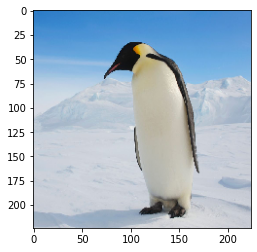

In [ ]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice
from keras.applications import ResNet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


res_model = ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)
#res_model.summary()

image_path = ['cat.jpeg', 'cow.jpeg','dog.jpeg','fish.jpeg','penguin.jpg']

for i in range(len(image_path)):
  original = load_img(image_path[i], target_size=(224, 224))
  print('Image size before processing is: ',original.size)

  numpy_image = img_to_array(original)

  image_batch = np.expand_dims(numpy_image, axis=0)
  plt.imshow(np.uint8(image_batch[0]))

  # prepare the image for the VGG model
  processed_image = preprocess_input(image_batch.copy())
  # get the predicted probabilities for each class
  predictions = res_model.predict(processed_image)
  label = decode_predictions(predictions)
  print (label)




#Reference:
#https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/




# **References**

https://scipy-lectures.org/advanced/image_processing/

https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/